<a href="https://colab.research.google.com/github/rnjsdn12332/GAN_study/blob/main/0628_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

성능을 더 향상시키는 법

1. 손실함수
-연속적인 숫자에 대해 결과를 출력하도록 구성되어 있는 회귀 문제는 평균제곱오차법(MSELoss)이 적합

-참, 거짓이 확실한 분류 문제는 
이진교차엔트로피 손실(BCELoss)이 적합
확실하게 틀리는 경우 큰 패널티를 주는 방식

우리의 문제는 두번째가 적합
BCELoss로 변환 후 훈련시키면 87%에서 91%로 향상함


2. 활성화 함수

-S모양 로지스틱 함수의 단점 : 기울기 굉장히 작아지다가 결국 사라질 수 있음(기울기 소실)
-->포화라고 부름

-정류 선형 유닛(ReLU)

기울기를 직선으로 긋는 방식
0보다 작은 값들에 대해는 경사가 0이기 때문에 이에따라 기울기가 소실되는 문제가 있음

-리키 ReLU

0보다 작은 경우는 미세한 기울기를 허용

->LeakyReLU(0.02)로 바꾸고 다시 실행하면 97%로 향상됌
//왼쪽 부분에 대한 기울기 0.02

3. 옵티마이저

-확률적 경사 하강법의 단점 : 

국소 최적해에 빠져버릴 확률이 큼

모든 학습 파라미터에 단일한 학습률을 적용한다는 점


-->Adam

국소최적해로 빠져버릴 가능성 줄임, 각각 다른 학습률 적용하고 학습 할 때 마다 이 파라미터들을 계속 상황에 따라 수정함

->self.optimiser=torch.optim.Adam(self.parameters()) 로 변경

대체로 SGD옵티마이저보다 나은 성능

4. 정규화

파라미터들의 범위를 감소하거나 평균을 0으로 맞춰주는 작업이 상당히 도움이 됨
이런 방법을 정규화라고 함

LayerNorm(200)을 추가해 최종 출력 레이어에 도착하기 직전에 네트워크에서의 신호를 모두 표준화

self.model=nn.Sequential(
    nn.Linear(784,200),
    nn.LeakyReLU(0.02),

    nn.LayerNorm(200),
    
    nn.Linear(200,10)
    nn.LeakyReLU(0.02)
)




91%로 성능이 좋아짐


모든 걸 다 복합해서 사용

self.model==nn.Sequential(
    nn.Linear(784,200),
    nn.LeakyReLU(0.02),

    nn.LayerNorm(200),
    
    nn.Linear(200,10)
    nn.Sigmoid()
    
)

-->BCE손실 은 0과 1 사이외의 값은 받을 수 없는, 리키 ReLU에서는 이 값이 나올 수 있기 때문에 맨 마지막에 sigmoid함수를 이용하고 리키 ReLU을 은닉 레이어 뒤로 이동

In [ ]:
from google.colab import drive
drive.mount('./mount')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

In [3]:
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):

        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        

        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        

        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [4]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

In [5]:
class Classifier(nn.Module):
    
    def __init__(self):

        super().__init__()
        

        self.model = nn.Sequential(
            nn.Linear(784, 200),
            #nn.Sigmoid(),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),
            
            nn.Linear(200, 10),
            nn.Sigmoid()
            #nn.LeakyReLU(0.02)
        )
        

        self.loss_function = nn.BCELoss()
        #self.loss_function = nn.MSELoss()


        self.optimiser = torch.optim.Adam(self.parameters())

  
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)
    
    
    def train(self, inputs, targets):

        outputs = self.forward(inputs)
        
        loss = self.loss_function(outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [6]:
%%time 


C = Classifier()



epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 12min 5s, sys: 7.05 s, total: 12min 12s
Wall time: 12min 13s


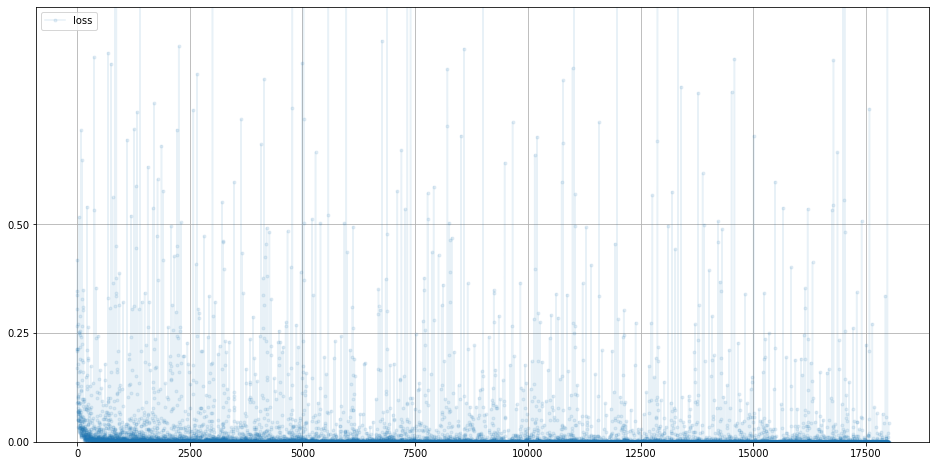

In [7]:
C.plot_progress()

In [8]:
mnist_test_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_test.csv')

In [5]:
record = 42

mnist_test_dataset.plot_image(record)

NameError: ignored

In [6]:
image_data = mnist_test_dataset[record][1]

output = C.forward(image_data)


pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

NameError: ignored

In [ ]:
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

In [ ]:
import torch

x=torch.cuda.FloatTensor([3,5])
x.device